In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from importlib import import_module
from dataset import CustomDataset
from transform import val_transform, test_transform
from torch.utils.data import DataLoader

import os 
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
# model 

load_path = "/opt/ml/finalproject/multilabel/multi-head_celoss_fulltrain_best.pth" # weight
N_CLASSES = 38
model_module = getattr(import_module("model"), "multihead")
model = model_module(num_classes=N_CLASSES, cls_classes = 6, device = device)
model.load_state_dict(torch.load(load_path))

<All keys matched successfully>

In [4]:
category_names = [
    'Aerosol', 
    'Alcohol', 
    'Awl', 
    'Axe', 
    'Bat', 
    'Battery', 
    'Bullet', 
    'Firecracker', 
    'Gun', 
    'GunParts', 
    'Hammer',
    'HandCuffs', 
    'HDD', 
    'Knife', 
    'Laptop', 
    'Lighter', 
    'Liquid', 
    'Match', 
    'MetalPipe', 
    'NailClippers', 
    'PortableGas', 
    'Saw', 
    'Scissors', 
    'Screwdriver',
    'SmartPhone', 
    'SolidFuel', 
    'Spanner', 
    'SSD', 
    'SupplymentaryBattery', 
    'TabletPC', 
    'Thinner', 
    'USB', 
    'ZippoOil', 
    'Plier', 
    'Chisel', 
    'Electronic cigarettes',
    'Electronic cigarettes(Liquid)', 
    'Throwing Knife'
]

In [5]:
# dataset
test_transform = CustomDataset(
    image_dir="/opt/ml/finalproject/data/",
    data_dir="/opt/ml/finalproject/data/eval/eval.json",
    mode="eval", 
    transform=val_transform
)
val_loader = DataLoader(
        dataset=test_transform,
        batch_size=64,
        num_workers=2,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=True,
    )

loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


In [6]:
test_transform[0]

(tensor([[[2.1633, 2.1633, 2.1633,  ..., 2.1633, 2.1633, 2.1633],
          [2.1633, 2.1633, 2.1633,  ..., 2.1633, 2.1633, 2.1633],
          [2.1633, 2.1633, 2.1633,  ..., 2.1633, 2.1633, 2.1633],
          ...,
          [2.1633, 2.1633, 2.1633,  ..., 2.1633, 2.1633, 2.1633],
          [2.1633, 2.1633, 2.1633,  ..., 2.1633, 2.1633, 2.1633],
          [2.1633, 2.1633, 2.1633,  ..., 2.1633, 2.1633, 2.1633]],
 
         [[2.3410, 2.3410, 2.3410,  ..., 2.3410, 2.3410, 2.3410],
          [2.3410, 2.3410, 2.3410,  ..., 2.3410, 2.3410, 2.3410],
          [2.3410, 2.3410, 2.3410,  ..., 2.3410, 2.3410, 2.3410],
          ...,
          [2.3410, 2.3410, 2.3410,  ..., 2.3410, 2.3410, 2.3410],
          [2.3410, 2.3410, 2.3410,  ..., 2.3410, 2.3410, 2.3410],
          [2.3410, 2.3410, 2.3410,  ..., 2.3410, 2.3410, 2.3410]],
 
         [[2.5529, 2.5529, 2.5529,  ..., 2.5529, 2.5529, 2.5529],
          [2.5529, 2.5529, 2.5529,  ..., 2.5529, 2.5529, 2.5529],
          [2.5529, 2.5529, 2.5529,  ...,

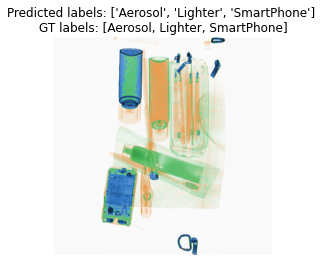

In [7]:
# Run inference on the test data
model.eval()

root_dir = "/opt/ml/finalproject/data/eval/"
li = [i+1 for i in range(100)]
for sample_id in [1]: #,2,3,4,6]:
    test_img, test_labels, file_name = test_transform[sample_id]
    with torch.no_grad():
        img = test_img[None,:] #.to(device)
        outs, cls_outs = model(img)
        raw_pred = torch.argmax(outs[0], dim=1)
    label_num = np.argwhere(raw_pred == 1)[0]
    predicted_labels = np.array(category_names)[label_num]
    if type(predicted_labels) != np.ndarray:
        predicted_labels = [predicted_labels]
    else:
        predicted_labels = list(predicted_labels)
    img_labels = np.array(category_names)[np.argwhere(test_labels.astype(int)==1)].T[0]
    image = test_img.permute(1,2,0).numpy() 
    original = Image.open(os.path.join(root_dir,file_name[1:]))
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    image =  (image*std) + (mean)

    plt.imshow(image)
    plt.title("Predicted labels: {} \nGT labels: [{}]".format(predicted_labels, ', '.join(img_labels)))
    plt.axis('off')